In [1]:
from catboost import CatBoostClassifier
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeImputer
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV

# seed
# import os
# import random
# os.environ['PYTHONHASHSEED']=str(271828)
# random.seed(271828)
# np.random.seed(271828)


Using TensorFlow backend.
C:\Anaconda\lib\site-packages\tensorflow-2.0.0a0-py3.6-win-amd64.egg\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\lib\site-packages\tensorflow-2.0.0a0-py3.6-win-amd64.egg\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\lib\site-packages\tensorflow-2.0.0a0-py3.6-win-amd64.egg\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:

In [2]:

def PCL_calculator(df):

    symptomatic_cutoff = 2
    intrusion = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'q6.4_UPSET', 'q6.5_PHYS']
    avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES', 'q6.9_DISINT', 'q6.10_DTACH',
                 'q6.11_NUMB', 'q6.12_FUTRE']
    tred = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH']
    only_avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES']
    hypertension = ['q6.13_SLEEP', 'q6.14_ANGER', 'q6.15_CONC', 'q6.16_HYPER', 'q6.17_STRTL']
    depression = ['q6.9_DISINT', 'q6.10_DTACH', 'q6.11_NUMB', 'q6.12_FUTRE']

    df[intrusion + avoidance + hypertension].fillna(df[intrusion + avoidance + hypertension].mean(axis=0))
    intrusion_cuoff = 1
    avoidance_cuoff = 3
    hypertension_cuoff = 2
    only_avoidance_cutoff = 1
    depression_cutoff = 2
    tred_cutoff = 1

    df['PCL_score'] = (df[intrusion + avoidance + hypertension]).sum(axis=1)
    df['PCL_mean'] = (df[intrusion + avoidance + hypertension]).mean(axis=1)
    df['PCL_std'] = (df[intrusion + avoidance + hypertension]).std(axis=1)
    

    df['intrusion'] = (df[intrusion] > symptomatic_cutoff).sum(axis=1)
    df['intrusion_mean'] = (df[intrusion] > symptomatic_cutoff).mean(axis=1)
    df['intrusion_std'] = (df[intrusion] > symptomatic_cutoff).std(axis=1)
    df['intrusion_cutoff'] = (df['intrusion'] >= intrusion_cuoff).astype(int)

    df['avoidance'] = (df[avoidance] > symptomatic_cutoff).sum(axis=1)
    df['avoidance_mean'] = (df[avoidance] > symptomatic_cutoff).mean(axis=1)
    df['avoidance_std'] = (df[avoidance] > symptomatic_cutoff).std(axis=1)
    df['avoidance_cutoff'] = (df['avoidance'] >= avoidance_cuoff).astype(int)

    df['depression'] = (df[depression] > symptomatic_cutoff).sum(axis=1)
    df['depression_mean'] = (df[depression] > symptomatic_cutoff).mean(axis=1)
    df['depression_std'] = (df[depression] > symptomatic_cutoff).std(axis=1)
    df['depression_cutoff'] = (df['depression'] >= depression_cutoff).astype(int)

    df['hypertention'] = (df[hypertension] > symptomatic_cutoff).sum(axis=1)
    df['hypertention_mean'] = (df[hypertension] > symptomatic_cutoff).mean(axis=1)
    df['hypertention_std'] = (df[hypertension] > symptomatic_cutoff).std(axis=1)
    df['hypertention_cutoff'] = (df['hypertention'] >= hypertension_cuoff).astype(int)

    df['tred'] = (df[tred] > symptomatic_cutoff).sum(axis=1)
    df['tred_mean'] = (df[tred] > symptomatic_cutoff).mean(axis=1)
    df['tred_std'] = (df[tred] > symptomatic_cutoff).std(axis=1)
    df['tred_cutoff'] = df['tred'] >= tred_cutoff

    df['only_avoidance'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_mean'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_std'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_cutoff'] = df['only_avoidance'] >= only_avoidance_cutoff

    #df['regression_cutoff_33'] = df['sum'] >= 33
    #df['regression_cutoff_50'] = df['sum'] >= 49
    df['diagnosis'] = ((df['hypertention_cutoff']) & (df['avoidance_cutoff']) & (df['intrusion_cutoff']) & (df['PCL_score'] >= 49))

    return df



In [3]:
path = "C:\‏‏PycharmProjects\PTSD\Data\PTSD.xlsx"
df = pd.read_excel(path)
#combine with specifics of answers
df_pcl2 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL2.xlsx")
df_pcl2 = PCL_calculator(df_pcl2)

df_pcl1 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL1.xlsx")
df_pcl1 = PCL_calculator(df_pcl1)

df = df.merge(df_pcl1, on="ID", how='outer')
df = df.merge(df_pcl2, suffixes=('_pcl1', '_pcl2'), on="ID", how='outer')

df_pcl3 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL3.xlsx")
df_pcl3 = PCL_calculator(df_pcl3)
df = df.merge(df_pcl3.drop(['PCL3_Strict', 'pcl3', 'PCL3_Broad'], axis=1), on="ID", how='outer')
# rmoving missing Y's
df = df[(df['PCL_score'] < 31) | (df['PCL_score'] > 48) ]
df = df[~df['PCL_Strict3'].isna()]
np.where(df['PCL_Strict3'] != df['diagnosis'])

(array([ 20, 425, 574], dtype=int64),)

## features 

In [4]:

features = ["highschool_diploma", "dyslexia",#"T2Acc1t", "T2Acc1n", "military_exposure_unit",
     "ADHD", "T1Acc1t", "T1Acc1n", "T1bias", 'Ashken_scale', 'Sephar_scale',
            "phq1", "lot1", "trait1",
                "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2", "trait2", "state2", "PCL2", "PCL_Broad2",
                "PCL_Strict2", "cd_risc1", "active_coping1", "planning1", "positive_reframing1", "acceptance1",
                "humor1",
                "religion1", "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2", "planning2",
                "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                "instrumental_support2",
                "self_distraction2", "denial2", "venting2", "substance_use2", "behavioral_disengagement2",
                "self_blame2",
                "trauma_history8_1", "HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5", 'q6.1_INTRU_pcl1', 
                'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                  'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                  'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                  'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                  'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                  'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                  'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                  'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2',
            
            'PCL_score_pcl1', 'PCL_mean_pcl1', 'PCL_std_pcl1', 
            'intrusion_pcl1', 'intrusion_mean_pcl1', 'intrusion_std_pcl1',
            'intrusion_cutoff_pcl1', 
            'avoidance_pcl1', 'avoidance_mean_pcl1', 'avoidance_std_pcl1', 'avoidance_cutoff_pcl1', 
            'depression_pcl1', 'depression_mean_pcl1', 'depression_std_pcl1', 'depression_cutoff_pcl1',
            'hypertention_pcl1',
            'hypertention_mean_pcl1', 'hypertention_std_pcl1', 'hypertention_cutoff_pcl1',
            'tred_pcl1', 'tred_mean_pcl1', 
            'tred_std_pcl1', 'tred_cutoff_pcl1', 
            'only_avoidance_pcl1','only_avoidance_mean_pcl1', 'only_avoidance_std_pcl1', 
            'only_avoidance_cutoff_pcl1',
            
            'PCL_score_pcl2', 'PCL_mean_pcl2', 'PCL_std_pcl2', 'intrusion_pcl2', 'intrusion_mean_pcl2', 'intrusion_std_pcl2',
            'intrusion_cutoff_pcl2', 'avoidance_pcl2', 'avoidance_mean_pcl2', 'avoidance_std_pcl2', 'avoidance_cutoff_pcl2', 
            'depression_pcl2', 'depression_mean_pcl2', 'depression_std_pcl2', 'depression_cutoff_pcl2', 'hypertention_pcl2',
            'hypertention_mean_pcl2', 'hypertention_std_pcl2', 'hypertention_cutoff_pcl2', 'tred_pcl2', 'tred_mean_pcl2', 
            'tred_std_pcl2', 'tred_cutoff_pcl2', 'only_avoidance_pcl2','only_avoidance_mean_pcl2', 'only_avoidance_std_pcl2', 
            'only_avoidance_cutoff_pcl2'
]

In [5]:
discrete_features = ["age", "highschool_diploma", "dyslexia", "ADHD", "phq1", "lot1",
                    "trait1", "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2",
                    "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2", "cd_risc1", "active_coping1",
                    "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2",
                    "planning2", "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                    "instrumental_support2", "self_distraction2", "denial2", "venting2", "substance_use2",
                    "behavioral_disengagement2", "self_blame2", "trauma_history8_1",
                    'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                    'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2',
                    'intrusion_cutoff', 'avoidance_cutoff', 'hypertention_cutoff', 'regression_cutoff_50']

In [6]:
genome_features = ["HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5"]
continuous_features = ["T1Acc1t", "T1Acc1n", "T1bias"]
t2_features = [
    "lot2", "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2", "phq2",

    "active_coping2", "planning2", "positive_reframing2", "acceptance2", "humor2", 
    "religion2", "emotional_support2", "instrumental_support2", "self_distraction2",
    "denial2", "venting2", "substance_use2", "behavioral_disengagement2", "self_blame2",
    
    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2', 'q6.5_PHYS_pcl2',
    'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2'
]
t1_features =[ "phq1", "lot1", "trait1","state1", "PCL1", "PCL_Broad1", "PCL_Strict1",
              
                    "active_coping1", "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1",
                'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1']

## fill the missing values

In [7]:
target_feature = ['PCL_Strict3']

In [8]:
df1 = df[features + target_feature]

#df1 = df1.dropna(thresh=47)
df_t1 = df1[t1_features]
df_t2 = df1[t2_features]
df1 = df1[(df_t1.isna().astype(int).sum(axis=1)<38) | (df_t2.isna().astype(int).sum(axis=1)<38)]
df1["t1_missing"] = df_t1.isna().astype(int).sum(axis=1)==38
df1["t2_missing"] = df_t2.isna().astype(int).sum(axis=1)==38
features.extend(["t1_missing", "t2_missing"])

    


In [9]:
from scipy.stats import zscore
def stds(X):
    X["outliers_count_t1_35"] = (np.abs(zscore(X[t1_features])) > 3.5).sum(axis=1)
    X["outliers_count_t1_25"] = (np.abs(zscore(X[t1_features])) > 2.5).sum(axis=1)
    X["outliers_count_t2_35"] = (np.abs(zscore(X[t2_features])) > 3.5).sum(axis=1)
    X["outliers_count_t2_25"] = (np.abs(zscore(X[t2_features])) > 2.5).sum(axis=1)
#    X['std_genome'] = X[genome_features].std(axis=1)
 #   X['std_t2'] = X[[ "trait2", "state2", "PCL2", "phq2"]].std(axis=1)
  #  X['std_t1'] = X[[ "trait1", "state1", "PCL1", "phq1"]].std(axis=1)

    X['std_pos_coping_t1'] = X[["active_coping1", "planning1", "positive_reframing1", "acceptance1", "humor1",
                    "religion1", "emotional_support1", "instrumental_support1", "self_distraction1","venting1"]].std(axis=1)

    X['std_neg_coping_t1'] = X[["denial1", "substance_use1", "behavioral_disengagement1", "self_blame1"]].std(axis=1)

    X['std_pos_coping_t2'] = X[["active_coping2", "planning2", "positive_reframing2", "acceptance2", "humor2",
                    "religion1", "emotional_support2", "instrumental_support2", "self_distraction2","venting2"]].std(axis=1)

    X['std_neg_coping_t2'] = X[["denial2", "substance_use2", "behavioral_disengagement2", "self_blame2"]].std(axis=1)
    return X

In [10]:
for i in t1_features:
    df1["delta_"+i[:len(i)-1:]] = df1[i] - df1[i[:len(i)-1:]+"2"]
    features = features + ["delta_"+i[:len(i)-1:]]

In [11]:
# for i in genome_features:
#     for j in ['Ashken_scale', 'Sephar_scale']:
#         df1[i + "_" + j] = df1[i] * df1[j] * 0.01
#         features = features + [i + "_" + j]
        

In [12]:
from statsmodels.formula.api import ols
def stats(X_train,X_test=None):
    if X_test is not None:
        m = ols('PCL_score_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
                'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
                'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
                'behavioral_disengagement1 + self_blame1',X_test.append(X_train, ignore_index=True)).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        X_test[['cooks_d_PCL_score_pcl2', 'dffits_PCL_score_pcl2', 'standard_resid_PCL_score_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']][:X_test.shape[0]:]

        m = ols('intrusion_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
                'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
                'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
                'behavioral_disengagement1 + self_blame1',X_test.append(X_train, ignore_index=True)).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame();
        X_test[['cooks_d_intrusion_pcl2', 'dffits_intrusion_pcl2', 'standard_resid_intrusion_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']][:X_test.shape[0]:]


        m = ols('avoidance_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
                'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
                'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
                'behavioral_disengagement1 + self_blame1',X_test.append(X_train, ignore_index=True)).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        X_test[['cooks_d_avoidance_pcl2', 'dffits_avoidance_pcl2', 'standard_resid_avoidance_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']][:X_test.shape[0]:]


        m = ols('depression_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
                'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
                'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
                'behavioral_disengagement1 + self_blame1',X_test.append(X_train, ignore_index=True)).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame();
        X_test[['cooks_d_depression_pcl2', 'dffits_depression_pcl2', 'standard_resid_depression_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']][:X_test.shape[0]:]


        m = ols('hypertention_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
                'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
                'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
                'behavioral_disengagement1 + self_blame1',X_test.append(X_train, ignore_index=True)).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        X_test[['cooks_d_hypertention_pcl2', 'dffits_hypertention_pcl2', 'standard_resid_hypertention_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']][:X_test.shape[0]:]
        return X_test
      
        
    else:
        m = ols('PCL_score_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
                'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
                'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
                'behavioral_disengagement1 + self_blame1',X_train).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        X_train[['cooks_d_PCL_score_pcl2', 'dffits_PCL_score_pcl2', 'standard_resid_PCL_score_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']]

        m = ols('intrusion_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
                'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
                'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
                'behavioral_disengagement1 + self_blame1',X_train).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        X_train[['cooks_d_intrusion_pcl2', 'dffits_intrusion_pcl2', 'standard_resid_intrusion_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']]


        m = ols('avoidance_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
                'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
                'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
                'behavioral_disengagement1 + self_blame1',X_train).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        X_train[['cooks_d_avoidance_pcl2', 'dffits_avoidance_pcl2', 'standard_resid_avoidance_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']]


        m = ols('depression_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
                'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
                'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
                'behavioral_disengagement1 + self_blame1',X_train).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        X_train[['cooks_d_depression_pcl2', 'dffits_depression_pcl2', 'standard_resid_depression_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']]


        m = ols('hypertention_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
                'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
                'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
                'behavioral_disengagement1 + self_blame1',X_train).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        X_train[['cooks_d_hypertention_pcl2', 'dffits_hypertention_pcl2', 'standard_resid_hypertention_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']]
        return X_train
        

In [13]:
def removal (X):
    useless_features = ["dyslexia", "PCL1", "PCL_Broad1", "PCL_Strict1", "PCL2", "PCL_Broad2",
                "PCL_Strict2",'q6.1_INTRU_pcl1', 
                'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                  'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                  'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                  'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                
                    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                  'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                  'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                  'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2',
            
]

    X = X.drop(useless_features, axis=1)
    return X

## cut off the test set

In [14]:
X, X_out, Y, y_out = train_test_split(df1[features], df1[target_feature[0]],
                                      test_size=0.25, random_state=1844, stratify=df1[target_feature[0]])


## the Model

## CV model of roc auc 

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [16]:

for i in range(11):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
    cv = StratifiedKFold(6)

    mice = IterativeImputer()
    X_train = pd.DataFrame(mice.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(mice.transform(X_test), columns=X_test.columns)
                    
    X_train = stds(X_train)
    X_test = stds(X_test)
    
    X_train = stats(X_train)
    X_test = stats(X_train, X_test)

    X_train = removal(X_train)
    X_test = removal(X_test)
    print(f"i = {i}")
    pipe = CatBoostClassifier(verbose=0)
        
    grid_params = [{
    'class_weights':[[1, 25], [1, 75]],
    #'grow_policy': ['SymmetricTree', 'Depthwiise', 'Lossguide'],
    'l2_leaf_reg': [150, 50],
    'depth': [6, 3]
    }]

    clf = GridSearchCV(pipe, grid_params, cv=cv, scoring='roc_auc')
    clf.fit(X_train, y_train.values.astype(int), early_stopping_rounds=15)
    print(f"i = {i}, roc_auc = {clf.best_score_}, params = {clf.best_params_}")
    y_pred_target = clf.best_estimator_.predict_proba(X_test)[:, 1]
    print(f"holdout i = {i}, roc_auc = {roc_auc_score(y_test.astype(int), y_pred_target)}")

i = 0
i = 0, roc_auc = 0.8934591428925706, params = {'class_weights': [1, 25], 'depth': 6, 'l2_leaf_reg': 50}
holdout i = 0, roc_auc = 0.8072289156626506
i = 1
i = 1, roc_auc = 0.8816732003700842, params = {'class_weights': [1, 75], 'depth': 6, 'l2_leaf_reg': 50}
holdout i = 1, roc_auc = 0.8654618473895582
i = 2
i = 2, roc_auc = 0.8734693488234565, params = {'class_weights': [1, 25], 'depth': 6, 'l2_leaf_reg': 50}
holdout i = 2, roc_auc = 0.8514056224899598
i = 3
i = 3, roc_auc = 0.8606432597934015, params = {'class_weights': [1, 75], 'depth': 6, 'l2_leaf_reg': 50}
holdout i = 3, roc_auc = 0.9437751004016064
i = 4
i = 4, roc_auc = 0.8620439522705812, params = {'class_weights': [1, 25], 'depth': 6, 'l2_leaf_reg': 50}
holdout i = 4, roc_auc = 0.9658634538152611
i = 5
i = 5, roc_auc = 0.8742443318930572, params = {'class_weights': [1, 25], 'depth': 6, 'l2_leaf_reg': 150}
holdout i = 5, roc_auc = 0.8413654618473896
i = 6
i = 6, roc_auc = 0.8839328125447106, params = {'class_weights': [1, 7

In [17]:
mice = IterativeImputer()
X = pd.DataFrame(mice.fit_transform(X), columns=X.columns)
X_out = pd.DataFrame(mice.transform(X_out), columns=X_out.columns)

In [18]:
X.columns

Index(['highschool_diploma', 'dyslexia', 'ADHD', 'T1Acc1t', 'T1Acc1n',
       'T1bias', 'Ashken_scale', 'Sephar_scale', 'phq1', 'lot1',
       ...
       'delta_q6.8_AMNES_pcl', 'delta_q6.9_DISINT_pcl',
       'delta_q6.10_DTACH_pcl', 'delta_q6.11_NUMB_pcl',
       'delta_q6.12_FUTRE_pcl', 'delta_q6.13_SLEEP_pcl',
       'delta_q6.14_ANGER_pcl', 'delta_q6.15_CONC_pcl',
       'delta_q6.16_HYPER_pcl', 'delta_q6.17_STRTL_pcl'],
      dtype='object', length=187)

In [19]:
X = stds(X)
X_out = stds(X_out)
X = stats(X)
X_out = stats(X, X_out)

In [20]:
X = removal(X)
X_out = removal(X_out)

In [21]:
pipe = CatBoostClassifier(verbose=0)
        
grid_params = [{
    'class_weights':[[1, 25], [1, 75]],
    #'grow_policy': ['SymmetricTree', 'Depthwiise', 'Lossguide'],
    'l2_leaf_reg': [150, 50],
    'depth': [6, 3]
    }]

clf = GridSearchCV(pipe, grid_params, cv=cv, scoring='roc_auc')
clf.fit(X_train, y_train.values.astype(int), early_stopping_rounds=15)
print(f"i = {i}, roc_auc = {clf.best_score_}, params = {clf.best_params_}")

i = 10, roc_auc = 0.8642630268692592, params = {'class_weights': [1, 25], 'depth': 6, 'l2_leaf_reg': 50}


In [22]:
y_pred_target= clf.predict_proba(X_out)[:, 1]

In [23]:
print(f"test roc_auc = {roc_auc_score(y_out, y_pred_target)}")

test roc_auc = 0.8838752488387525


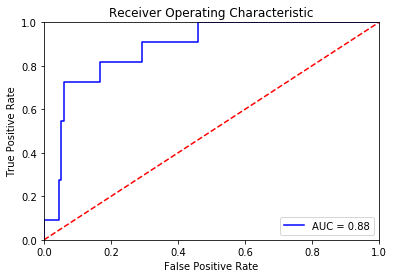

In [24]:

fpr, tpr, threshold = roc_curve(y_out, y_pred_target)
roc_auc = auc(fpr, tpr)

                    # method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 